# **Распознавание опасных растений**

---

In [76]:
#Импортируем библиотеки
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Раскомментируйте код ниже при работе в Colab

In [ ]:
#from google.colab import drive
#from google.colab import files

### Загружаем датасет
Способ 1. При использовании локальной среды разработки - через путь к файлу

Способ 2. При использовании Colab - через путь к папке в Google disk

---

In [77]:
# Способ 1. Укажите путь к папке с датасетом

dataset_dir = pathlib.Path("Hazardous plants")

In [3]:
# # Способ 2. Укажите путь к папке в Google drive

# drive.mount('/content/drive')
# dataset_dir = pathlib.Path('/content/drive/MyDrive/Project/flower_photos')

In [78]:
# Количество изображений в датасете
image_count = len(list(dataset_dir.glob("*/*.jpg")))
print(f"Всего изображений: {image_count}")

Всего изображений: 898


### Разделение на обучающую и тестовую выборку

80% - обучающая выборка;

20% - тестовая выборка.

---

In [79]:
# Определение параметров для обработки изображений
batch_size = 32 # Размер батча - количество изображений, обрабатываемых за один раз
img_width = 180
img_height = 180

# Создание тренировочного датасета из директории с изображениями
train_ds = tf.keras.utils.image_dataset_from_directory(
	dataset_dir,
	validation_split=0.2,
	subset="training",
	seed=123,
	image_size=(img_height, img_width),
	batch_size=batch_size)

# Создание тестового датасета из той же директории
val_ds = tf.keras.utils.image_dataset_from_directory(
	dataset_dir,
	validation_split=0.2,
	subset="validation",
	seed=123,
	image_size=(img_height, img_width),
	batch_size=batch_size)

class_names = train_ds.class_names
print(f"Class names: {class_names}")

# # Оптимизация производительности датасетов
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1251 files belonging to 11 classes.
Using 1001 files for training.
Found 1251 files belonging to 11 classes.
Using 250 files for validation.
Class names: ['Abrus precatorius', 'Madagascar periwinkle', 'castor_oil_plant', 'dieffenbachia', 'foxglove', 'lilies', 'lily_of_the_valley', 'oleander', 'pothos', 'rhubarb', 'wisteria']


### Создаем модель, компилируем её и выводим summary

---



In [80]:
# Создание модели
# Количество классов равно количеству поддиректорий в dataset_dir
num_classes = len(class_names)
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # Первый слой: нормализация значений пикселей

    # Сверточные блоки
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

# Компиляция модели
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

# Вывод структуры модели
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_13 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,990,059 (15.22 MB)

 Trainable params: 3,990,059 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Обучаем нейросеть и выводим графики точности

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.1688 - loss: 2.3968 - val_accuracy: 0.2560 - val_loss: 2.1259
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.3716 - loss: 1.8795 - val_accuracy: 0.4000 - val_loss: 1.8113
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5425 - loss: 1.4708 - val_accuracy: 0.4400 - val_loss: 1.5915
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6184 - loss: 1.1848 - val_accuracy: 0.4560 - val_loss: 1.5300
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7033 - loss: 0.9300 - val_accuracy: 0.5440 - val_loss: 1.3876
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.8452 - loss: 0.5497 - val_accuracy: 0.5600 - val_loss: 1.5138
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.9291 - loss: 0.2798 - val_accuracy: 0.5040 - val_loss: 1.9476
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.9580 - loss: 0.1956 - val_accuracy: 0.5120 

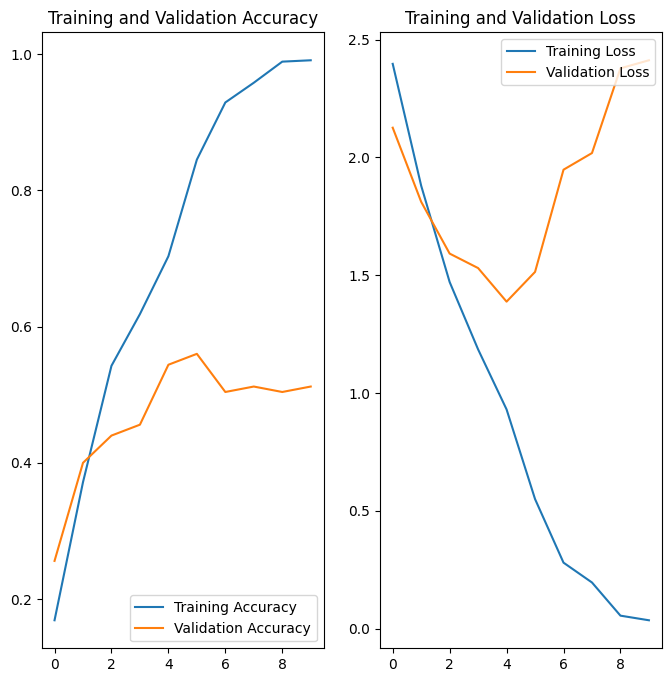

In [81]:
# Обучение модели
epochs = 10 # количество эпох тренировки
history = model.fit(
	train_ds,
	validation_data=val_ds,
	epochs=epochs)

# Извлечение метрик точности из истории обучения
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Извлечение значений функции потерь из истории обучения
loss = history.history['loss']
val_loss = history.history['val_loss']

# Создание диапазона эпох для построения графиков
epochs_range = range(epochs)

# Создание графика для визуализации процесса обучения
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Промежуточный результат: Увеличение Loss на тестовых данных - признаки переобучения

### Аугментация и регуляризация для предотвращения переобучения

In [82]:
model = Sequential([
    # Нормализация значений пикселей
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    layers.RandomFlip("horizontal"), # Случайное горизонтальное отражение (зеркалирование)
    layers.RandomRotation(0.1), # Поворачивает изображение на случайный угол в пределах ±10% от 360 градусов
    layers.RandomZoom(0.1), # Увеличивает или уменьшает изображение на случайную величину до ±10%
    layers.RandomContrast(0.2), # Изменяет контрастность изображения случайным образом в пределах ±20%

    # Сверточные блоки
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Регуляризация
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

# Компиляция модели
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Вывод структуры модели
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_14 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_7 (RandomFlip)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_8               │ (None, 180, 180, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_7 (RandomZoom)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_6               │ (None, 180, 180, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,990,059 (15.22 MB)

 Trainable params: 3,990,059 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Повторно обучаем нейросеть с новыми слоями и увеличенным количеством эпох обучения

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.1209 - loss: 2.6233 - val_accuracy: 0.1320 - val_loss: 2.2959
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.2338 - loss: 2.1477 - val_accuracy: 0.2840 - val_loss: 2.0422
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.3926 - loss: 1.8226 - val_accuracy: 0.3200 - val_loss: 1.8935
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.4615 - loss: 1.5761 - val_accuracy: 0.4040 - val_loss: 1.7807
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.5035 - loss: 1.4498 - val_accuracy: 0.4560 - val_loss: 1.5719
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.5495 - loss: 1.3484 - val_accuracy: 0.4960 - val_loss: 1.4955
Epoch 7/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.5734 - loss: 1.2829 - val_accuracy: 0.4720 - val_loss: 1.4470
Epoch 8/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.6184 - loss: 1.2054 - val_accuracy: 0.48

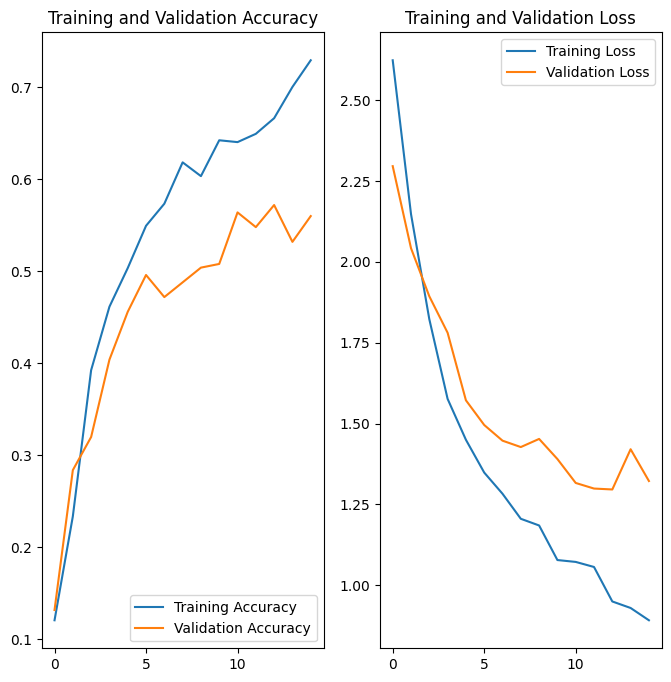

In [83]:
# Повторное обучение модели
epochs = 15 # количество эпох тренировки
history = model.fit(
	train_ds,
	validation_data=val_ds,
	epochs=epochs)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

После аугментации и регуляризации наблюдаем снижение losses на обучении

### Тест модели на новых изображениях

---

99387/99387 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
На изображении скорее всего oleander (85.50% вероятность)


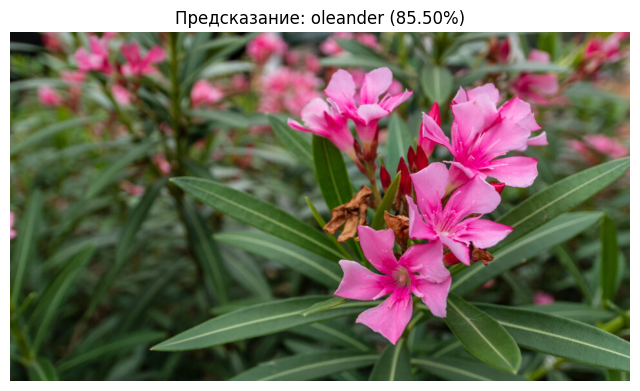

In [86]:
# Загрузка изображения
def display_image_with_prediction(image_url, name):
    # Закрываем все открытые фигуры
    plt.close('all')

    # Загрузка и обработка изображения
    flower_path = tf.keras.utils.get_file(name, origin=image_url)

    img = tf.keras.utils.load_img(flower_path, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print("На изображении скорее всего {} ({:.2f}% вероятность)".format(
        class_names[np.argmax(score)], 100 * np.max(score)))

    # Создаем новую фигуру
    fig = plt.figure(figsize=(8, 6))
    image = mpimg.imread(flower_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Предсказание: {class_names[np.argmax(score)]} ({100 * np.max(score):.2f}%)")
    plt.show()
    plt.close()

    return fig

# Вставить URL-ссылку на изображение и имя файла (укажите произвольное)
fig0 = display_image_with_prediction("https://s13.stc.all.kpcdn.net/family/wp-content/uploads/2021/12/top-oleandr-960x540-1-960x540.jpg", 'oleander1')

9572/9572 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
На изображении скорее всего foxglove (62.74% вероятность)


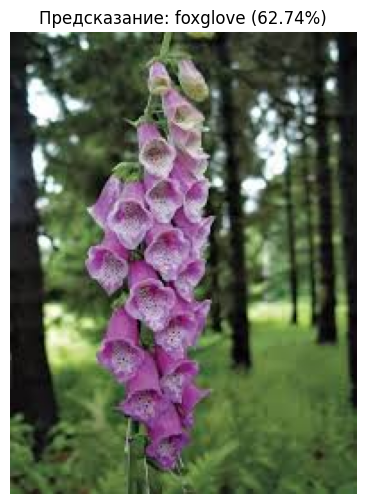

In [88]:
fig2 = display_image_with_prediction("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTvSNLEeDk0D7yNBW4ksES5af6y03tbVwN6UA&s", 'foxglove1')

10936/10936 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
На изображении скорее всего wisteria (94.41% вероятность)


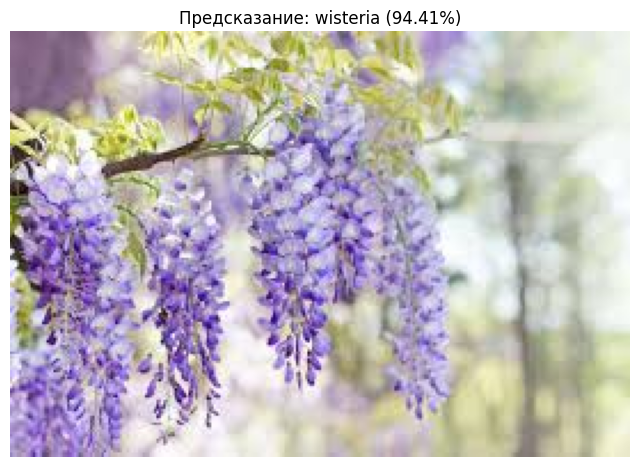

In [89]:
fig1 = display_image_with_prediction("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRlt6wZQEJ0CfN75cM8hloPc0tE4YHDJbEyAQ&s", 'wisteria')

364972/364972 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
На изображении скорее всего dieffenbachia (33.76% вероятность)


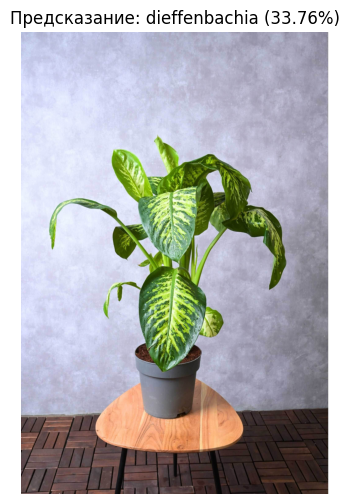

In [91]:
fig2 = display_image_with_prediction("https://adplants.com/cdn/shop/files/indoor-plant-default-plastic-dieffenbachia-compacta-dieffenbachia-compacta-1172621453.jpg?v=1753871887", 'dieffenbachia1')

657167/657167 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
На изображении скорее всего castor_oil_plant (33.92% вероятность)


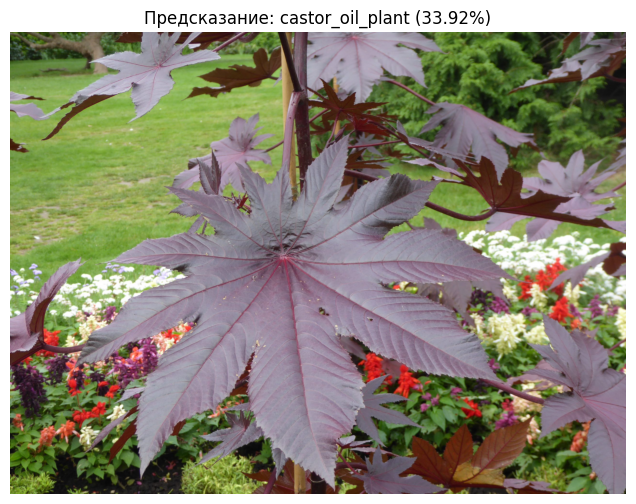

In [92]:
fig3 = display_image_with_prediction("https://www.animalpoisonline.co.uk/wp-content/uploads/2022/11/Ricinus-communis-September-12-scaled.jpg", 'castor_oil_plant')

316462/316462 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
На изображении скорее всего rhubarb (65.04% вероятность)


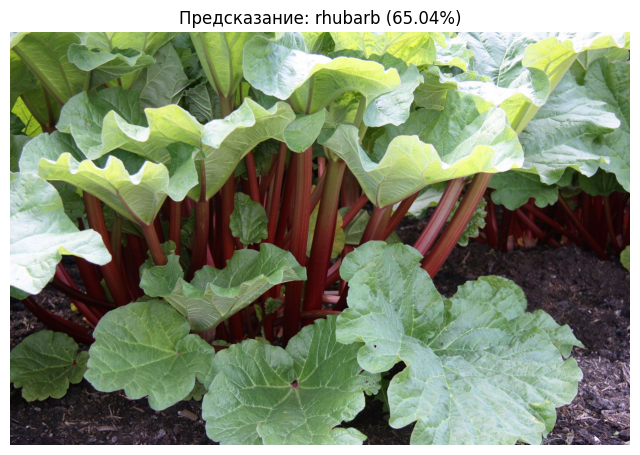

In [93]:
fig4 = display_image_with_prediction("https://cdn.britannica.com/28/197528-050-2F119484/Garden-rhubarb.jpg", 'rhubarb')

104093/104093 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
На изображении скорее всего Abrus precatorius (75.16% вероятность)


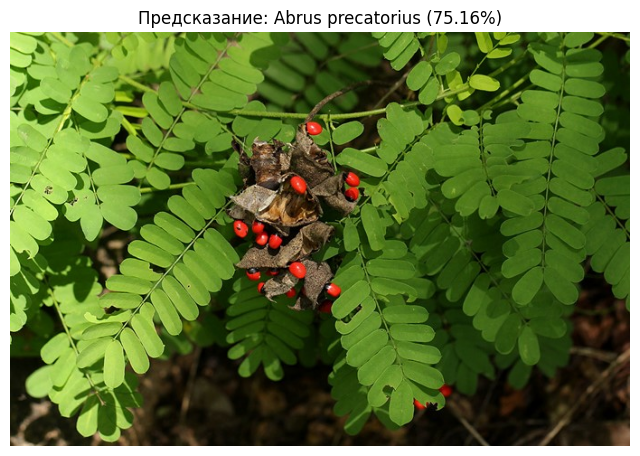

In [94]:
fig5 = display_image_with_prediction("https://www.gastronomiac.com/wp/wp-content/uploads/2021/04/Arbuste-abrus-precatorius.jpg", 'Abrus precatorius')

620179/620179 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
На изображении скорее всего pothos (36.51% вероятность)


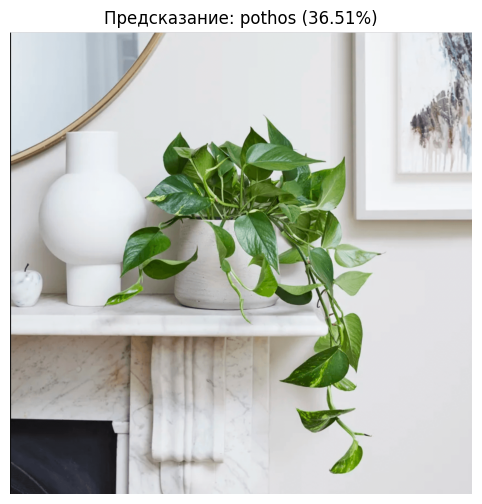

In [101]:
fig5 = display_image_with_prediction("https://media.houseandgarden.co.uk/photos/64bff5f4d6a55acd0397054e/1:1/w_1342,h_1342,c_limit/Screenshot%202023-07-25%20at%2017.17.10.png", 'pothos6')

59961/59961 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
На изображении скорее всего lily_of_the_valley (35.99% вероятность)


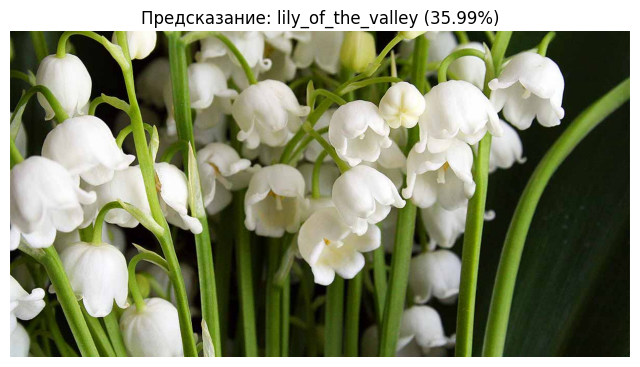

In [102]:
fig5 = display_image_with_prediction("https://gardenerspath.com/wp-content/uploads/2018/03/How-to-Grow-Fragrant-C.-Majalis.jpg", 'lily_of_the_valley')

### Скачать модель на компьютер

In [ ]:
model_file_name = "hazardous_plants.h5"

# save model
model.save(model_file_name)

# Скачать модель (закомментировать при работе в локальной IDE)
#files.download(model_file_name)